In [1]:
import os
import sys

import importlib
import torch
import logging
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle, Patch

import pandas as pd
import numpy as np
from tqdm import tqdm
from munch import Munch

from src.data.fingerprint import calculate_fingerprint_similarity
from src.data.datazoo import get_dataloaders
from src.toolkit.config import build_config, yaml_to_munch

/home/dscheliga/.conda/envs/FFP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dscheliga/.conda/envs/FFP/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/dscheliga/.conda/envs/FFP/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c104warnERKNS_7WarningE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Initialize the datasets with the corresponding experiment configuration to trigger Fingerprint Computation 
### choice between PACFL and FFP as fingerprinting mechanism

In [2]:
#fingerprinting_mechanism = 'PACFL'
fingerprinting_mechanism = 'FFP'

config = build_config('configs/experiments/IsolatedBaseline.yaml')

if fingerprinting_mechanism == 'PACFL':
    fp_config = yaml_to_munch('configs/bases/fingerprint/PACFL.yaml')
elif fingerprinting_mechanism == 'FFP':
    fp_config = yaml_to_munch('configs/bases/fingerprint/FFP.yaml')


config.data_distribution_config.fingerprint = fp_config.data_distribution_config.fingerprint

dataloaders = get_dataloaders(config.data, True, config)

Loading config from file: configs/experiments/IsolatedBaseline.yaml
Loading config from file: configs/bases/paths.yaml
Loading config from file: configs/bases/training/Isolated.yaml
Loading config from file: configs/bases/data/MBIsolated.yaml
Loading config from file: configs/bases/models/CNNPFL.yaml
Start loading multiple benchmark datasets as federated dataset with 5 clients (['MNIST', 'FashionMNIST', 'SVHN', 'CIFAR10', 'CIFAR100']) that are split into ([1, 1, 1, 1, 1]) clients each respectively.
Loading data for 1 clients for MNIST
Created central dataloaders for MNIST dataset. Transformed them with:
None
Batchsize: 256 | Trainbatches: 234 | Testbatches: 40 | Validationbatches: 0
Splitting central dataset into federated client datasets with a IID partitioning!
Loading distribution from ./data/federated_distributions/NC_1_partition_mode_IID_dataset_MNIST_split_TRN_seed_42.tdump
Loading distribution from ./data/federated_distributions/NC_1_partition_mode_IID_dataset_MNIST_split_TST_se

In [3]:
if fingerprinting_mechanism == 'PACFL':
    fp_path = 'data/fingerprints/NC_5_partition_mode_IID_dataset_MixedBenchmark_seed_42_SVD_raw_FPs.tdump'
elif fingerprinting_mechanism == 'FFP':
    fp_path = 'data/fingerprints/NC_5_partition_mode_IID_dataset_MixedBenchmark_seed_42_SVD_features_MobileNetS_FPs.tdump'

fp_dict = torch.load(fp_path)

# Compute Similarity Matrices...

In [4]:
sim_matrix, sim_calculator = calculate_fingerprint_similarity(fp_dict, 'PrincipalAngles')

Calculating similarity matrix!


# Illustration of Proximity Matrix

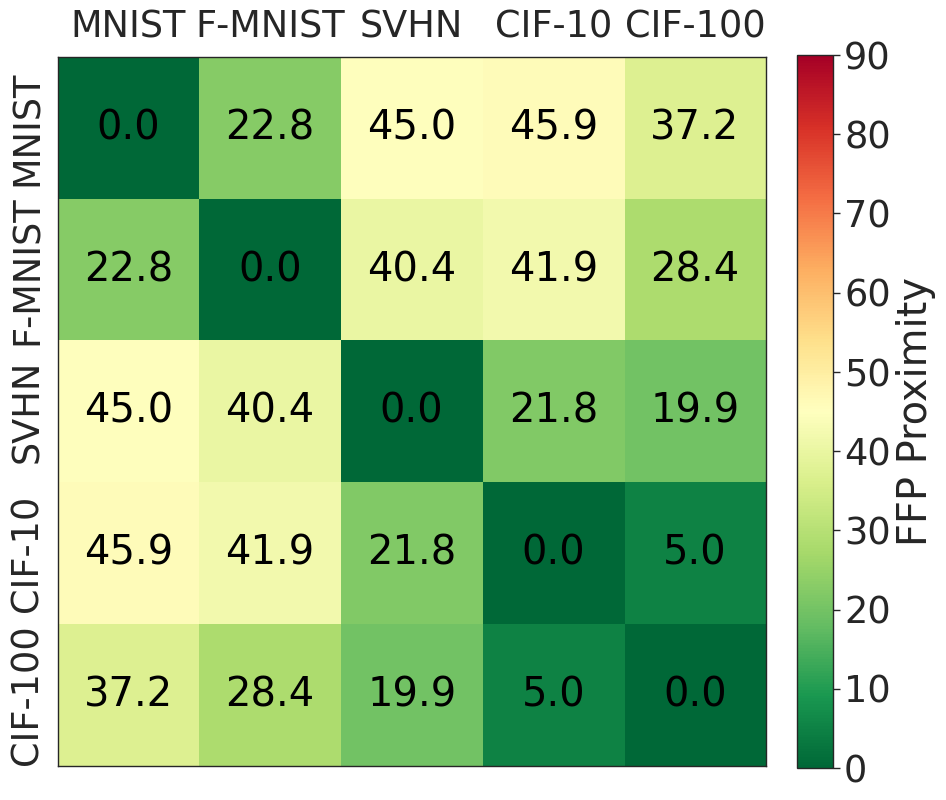

In [5]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=3, rc={"text.usetex": True})

names = ['MNIST', 'F-MNIST', 'SVHN', 'CIF-10', 'CIF-100']

#plot similarity matrix with matplot
plt.figure(figsize=(10, 10))
plt.imshow(sim_matrix, cmap='RdYlGn_r', interpolation='nearest', vmax=90)
#make colorbar fit the main plot
plt.colorbar(fraction=0.046, pad=0.04, label=f'{fingerprinting_mechanism} Proximity')

#show values in heatmap
for i in range(len(names)):
    for j in range(len(names)):
        plt.text(i, j, round(sim_matrix[i, j], 1), ha="center", va="center", color="black")



plt.xticks(np.arange(len(names)), names, rotation=0)
plt.yticks(np.arange(len(names)), names, rotation=0)

plt.xticks(np.arange(len(names)), names, rotation=0)
plt.yticks(np.arange(len(names)), names, rotation=90, va='center')
#have x tick labels at top instead of bottom
plt.tick_params(axis='x', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False, labeltop=True)
plt.tick_params(axis='y', which='both', bottom=False, top=False, left=False, right=False, labelleft=True)

#plt.yticks(np.arange(len(names)), names, rotation=0)

plt.show()
plt.close()